In [3]:
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
import math
#import scienceplots
#plt.style.use(['science','nature','no-latex','vibrant'])
from scipy import constants

#Import personal functions
import sys
sys.path.append("C:/Users/Olivi/Documents/Git/SoRoMa/Thermal_Soft_Robotics_data/Functions")
#sys.path.append("C:/Users/Olivi/OneDrive - TU Eindhoven/Soft robotic matter/GitHub/Thermal_Soft_Robotics/Functions")
#sys.path.append("//sun/overvelde/group-folder/PROJECTS/Thermal_soft_robotics_Olivier/Git/Thermal_Soft_Robotics/Functions")
import FluidicSetupFunctions
from save_plot_func import save_plot
#import main_extended_functions 
from scipy.integrate import solve_ivp

from main_extended_functions import *

In [4]:

# Load constants 
k = constants.k # boltzman constant?
pi = constants.pi
sigmna = constants.sigma # Stefan–Boltzmann constant
R = constants.R # gas constant

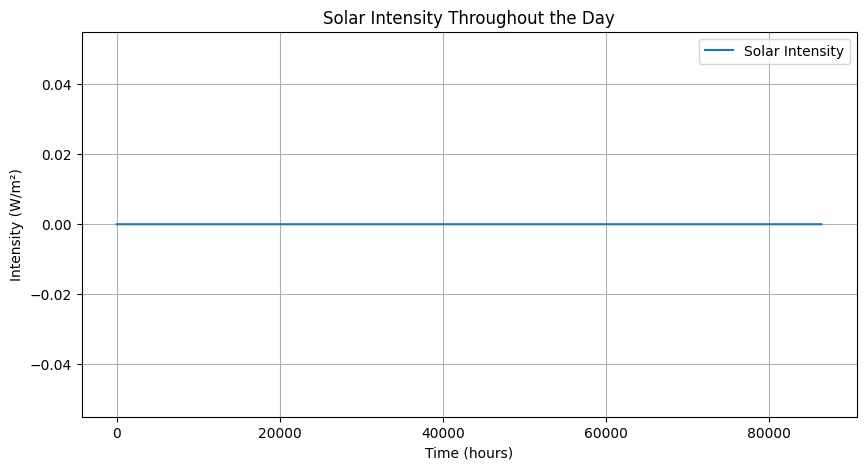

In [5]:
# Time array from 0 to 24 hours (one day)
t = np.linspace(0, 24*3600, 3600)

# Solar intensity function
def I(t, peak):
    if 6*3600 <= t <= 18*3600:
        return 0#peak * np.sin((np.pi / (12*3600)) * (t - 6*3600))
    else:
        return 0

# Vectorize the function so it can operate on arrays
vectorized_solar_intensity = np.vectorize(I)

# Calculate intensity values
intensity = vectorized_solar_intensity(t, 1300)

# Plotting the graph
plt.figure(figsize=(10, 5))
plt.plot(t, intensity, label="Solar Intensity")
plt.title("Solar Intensity Throughout the Day")
plt.xlabel("Time (hours)")
plt.ylabel("Intensity (W/m²)")
#plt.xticks(np.arange(0, 25*3600, 1))
plt.grid(True)
plt.legend()
plt.show()

In [6]:
def system(t, y, **params):
    T_g, T_co, T_air, T_p, T_n, n_g, n_l, P= y
  
    # Unpack parameters for use in the function
    alpha_g = params['alpha_g']
    A_g = params['A_g']
    t_g = params['t_g']
    rho_g = params['rho_g']
    c_g = params['c_g']
    epsilon_g = params['epsilon_g']
    m_g = params['m_g']

    alpha_c = params['alpha_c']
    k_c = params['k_c']
    r_c = params['r_c']
    h_c = params['h_c']
    A_co = params['A_co']
    t_c = params['t_c']
    A_ci = params['A_ci']
    A_con = params['A_con']
    rho_c = params['rho_c']
    m_c = params['m_c']
    c_c = params['c_c']
    tau_c = params['tau_c']
    epsilon_paint = params['epsilon_paint']
    V_c = params['V_c']

    rho_air = params['rho_air']
    V_air = params['V_air']
    c_air = params['c_air']
    n0_air = params['n0_air']

    A_p = params['A_p']
    n = params['n']
    m_p = params['m_p']
    c_p = params['c_p']
    D_p = params['D_p']

    # Novec properties
    c_n = params['c_n']
    M_n = params['M_n']
    m_n = params['m_n']
    latent_heat = params['latent_heat']
    boiling_point = params['boiling_point']
    nu_n_g = params['nu_n_g']
    n_n = params['n_n']

    # Environmental properties
    T_s = params['T_s']
    T_amb = params['T_amb']
    v = params['v']
    I_peak = params['I_peak']

    # Assume inside container is a fraction colder than the outside 
    T_ci = 0.9999*T_co

    #Convection of the ground 
    h_cga = 5.7+3.8*v   # Convection from ground to ambient, formula 11 from paper # F 3.29a
    h_cgc = 0 # Convection from ground to container
    h_rgc = 0# epsilon_paint*constants.sigma*(T_g**2+T_s**2)*(T_g+T_s) # Radiation from ground to container  
   
    #K_air = 5.75*10**-5*(1+0.00317*T_air-0.0000021*T_air**2) # Thermal conductivity of air,doi: https://sci-hub.se/https://doi.org/10.1071/CH9510305
    #h_cca = h_cpn(A_c, D_c,L, K_air, Cp_air,delta_T, mu_air, nu_air, beta_air )
    
    # Convection from container to enclosed air 
    h_rcs = 0 #epsilon_paint*constants.sigma*(T_co**2+T_s**2)*(T_co+T_s) # Radiation from container to sky

    # Calculate T_g 
    h_rga  = epsilon_g*constants.sigma*(T_g**2+T_s**2)*(T_g+T_s) # Radiation from ground to ambient
    E_in_g = I(t,I_peak)*alpha_g*A_g 
    E_out_g = h_cga*A_g*(T_g-T_amb)+(t_c/k_c)*A_con*(T_g-T_co)+h_rga*(T_g-T_s)*A_g
    dT_g_dt = (E_in_g-E_out_g)/(m_g*c_g)

    # Calculate T_co
    h_cca = h_cpn(A_co, 2*pi*r_c ,h_c, k_c, c_air,T_air, T_ci ,rho_air,mu_air(T_air))
    E_in_c = A_co/2 *I(t,I_peak)*alpha_c+(t_c/k_c)*A_con*(T_g-T_co)
    E_out_c = A_co/2*h_rcs*(T_co-T_s)+h_cac(v,(2*r_c))*A_co*(T_co-T_amb)+h_cca*A_ci*(T_co-T_air)
    dT_co_dt  = (E_in_c-E_out_c)/(m_c*c_c)


    if T_ci > T_air:
        E_in_air = h_cca*A_ci*(T_ci-T_air)#I(t,I_peak)*tau_c*A_co/2+
        E_out_air = 0
        #print(E_in_air, E_out_air)
        #print(h_cca)
    else: # T_air > T_ci
        E_in_air =0 #I(t,I_peak)*tau_c*A_co/2
        E_out_air = h_cca*A_ci*(T_air-T_ci)
    dT_air_dt  = (E_in_air-E_out_air)/(rho_air*V_air*c_air)

    
    # Calculate T_pouch and T_novec 
    E_in_p = h_cap(2*(r_c-t_c),2*r_c)*A_p*(T_air-T_p)
 
    gamma =  n_l/n_n # The ratio of the volume of liquid novec to the volume of gas novec
    
    #Convetion in pouches 
    V_air = n0_air*R*T_air/P # Volume of air in pouches
    V_p = V_c - V_air # Volume of novec in pouches
    m_n_gas = (1-gamma)*M_n # Mass of novec gas in pouches
    rho_n_g = m_n_gas/V_p
    h_cpn_g = h_cpn(A_p, 2*pi*D_p ,L_p, K_n, c_n, T_n, T_p, rho_n_g, nu_n_g)# Convection from pouch to novec gas 
    h_cpn_l =h_cpn(A_p, 2*pi*D_p ,L_p, K_n, c_novec(T_n),T_n, T_p, rho_n_l(T_n), mu_novec(T_n)) # Convection from pouch to novec liquid 
    E_out_p = gamma*h_cpn_g*2*A_p*(T_p-T_n) + (1-gamma)*h_cpn_l*2*A_p*(T_p-T_n) if abs(T_p-T_n)>1e-10 else 0

    dT_p_dt  = (E_in_p-E_out_p)/(n*m_p*c_p)
    #print('dT_p_dt = ', dT_p_dt, E_in_p, E_out_p, n*m_p*c_p)
    
    # Model T_n and boiling + evaporation
    dT_n_dt = dT_p_dt
    
    evaporation_rate = 0
    condensed_moles = 0
    evaporated_moles = 0
    dn_l_dt = 0
    dn_g_dt = 0


    
    heat_flux_n = E_out_p
    
    if T_n > boiling_point: 
        if n_l > 1e-6: # Evaporating novec
            dT_n_dt =0
            evaporation_rate = min(abs(heat_flux_n / latent_heat )  * M_n, n_l)
            dn_g_dt =+ evaporation_rate
            dn_l_dt =- dn_g_dt
        else : # Heating gas novec
            dT_n_dt = heat_flux_n/(m_n*c_n)

    else: # in other words T_n < T_boil 
        if n_g > 1e-6: # below boiling point and gas present
            dT_n_dt = 0
            condensation_rate = min(abs(heat_flux_n / latent_heat) * M_n, n_g)
            dn_l_dt = min(condensation_rate, n_g)
            dn_g_dt = -dn_l_dt
        else: 
            dT_n_dt = heat_flux_n/(m_n*c_n)

    
    dP_dt = ((n0_air+n_g)*R*dT_air_dt)/V_c

    print('t = ', t)
    #print(dT_g_dt, dT_co_dt, dT_air_dt, dT_p_dt, dT_n_dt, dn_g_dt, dn_l_dt, dP_dt) 

    return [dT_g_dt, dT_co_dt, dT_air_dt, dT_p_dt, dT_n_dt, dn_g_dt, dn_l_dt, dP_dt]
      

In [8]:
# System parameters 
# Ground 
alpha_g = 0.91 # Ashalth roofing, new https://www.engineeringtoolbox.com/solar-radiation-absorbed-materials-d_1568.html
A_g = 1 # Area ground [m^2]
t_g = 50e-3 # Thickness ground [m]
rho_g = 2.36e3 # Density ground [kg/m^3] https://www.engineeringtoolbox.com/density-solids-d_1265.html
m_g = rho_g*A_g*t_g # Mass ground [kg]
c_g = 920 # Specific heat capacity ground [J/kg/K] https://www.engineeringtoolbox.com/specific-heat-capacity-d_391.html
epsilon_g = 0.93 # Black body radiation [-] https://www.engineeringtoolbox.com/emissivity-coefficients-d_447.html

# Container properties
alpha_c =0.9 # absorption constant container 
k_c = 1200 # specific heat capacity container  ( J.K-1.kg-1 ) https://www.azom.com/article.aspx?ArticleID=2047

r_c = 0.1/2 # radius container
h_c = 0.3 # height container

A_co = 2*pi*r_c*h_c # Area container [m^2], assumed cilinder 
t_c= 1.5e-3 # thickness container [m]
A_ci = 2*pi*(r_c-t_c)*(h_c-2*t_c)# Area inside container 
A_con = 0.01*A_co
rho_c  = 1.35e3 # density container [kg/m^3]
m_c = 2*pi*(r_c**2-(r_c-t_c)**2)*h_c*rho_c # Mass container [kg]
c_c = 1550 # Specific heat capacity polyethylene  [J/kg/K] https://www.engineeringtoolbox.com/specific-heat-polymers-d_1862.html
tau_c = 0.01 # Transmission of the sun through the container (assumed)
epsilon_paint= 0.9 # Black body radiation [-] https://help.covetool.com/en/articles/5560310-wall-emissivity
k_c = 0.50  # Thermal conductivity of the container (Polyethylene, high density (PEH)) [W/m/K] https://www.engineeringtoolbox.com/thermal-conductivity-plastics-d_1786.html
V_c = A_ci*h_c # Volume container [m^3]


# Pouch properties
D_p = 0.1 # Diameter pouch [m]
L_p = 0.2 # Length pouch [m]
A_p = 2*D_p*L_p # Area pouch m^2 
n=1 # number of pouches
t_p = 0.5e-3 # Thickness pouch [m]
rho_p = 1.28 # Density tpu [kg/m^3] https://matweb.com/search/DataSheet.aspx?MatGUID=2fe782a31c4b4bed984b49651762b086&ckck=1
m_p = 2*A_p*t_p*rho_p # Mass pouch [kg]
c_p = 1500 # Specific heat capacity tpu [J/kg/K] https://matmatch.com/materials/mbas116-urethane-thermoplastic-elastomer-tpu-

# Novec properties
c_n = 1300 # Specific heat capacity novec [J/kg/K] source: datasheet
M_n = 200e-3 # Molar mass novec [kg/mol] source: datasheet
m_n = 3.7e-3 # Mass novec [kg] source: datasheet
n_n = m_n/M_n # Amount of novec in pouches [mol]
boiling_point = 34+273.15 # Boiling point novec [K] source: datasheet
latent_heat = 142e3 # Latent heat of vaporization novec [J/kg] source: datasheet
K_n = 0.075 # Thermal conductivity novec [W/m/K] source: datasheet
nu_n_g = 0.32e-3 # Kinematic viscosity novec gas [m^2/s] source: datasheet 


# Env properties
T_s = 53+273.15 # Temperature of the sky
T_amb = 50+273.15 # Temperature of the ambient air
v = 2 # Wind speed m/s
I_peak = 1300 # Peak intensity of the sun W/m^2
P_amb = 1e5 # Ambient pressure Pa

#Air properties 
rho_air = 1.293 # density air kg/m^3
V_air = 2*pi*(r_c-t_c)*h_c # Volume air in container
c_air= 	1.0035 # specific heat capacity air J/kg/K https://en.wikipedia.org/wiki/Table_of_specific_heat_capacities
P_amb = 1e5
n0_air = P_amb*V_c/(R*T_amb) # initial amount of air in container
mol_mass_air = 28.97e-3 # kg/mol https://en.wikipedia.org/wiki/Molar_mass#:~:text=Average%20molar%20mass%20of%20mixtures,-The%20average%20molar&text=As%20an%20example%2C%20the%20average,air%20is%2028.97%20g%2Fmol.
m_air = n0_air*mol_mass_air # mass of air in container


In [9]:
# Make dictionary of all constants 
# System parameters in a dictionary
params = {
    # Ground parameters
    "alpha_g": alpha_g,
    "A_g": A_g,
    "t_g": t_g,
    "rho_g": rho_g,
    "c_g": c_g,
    "epsilon_g": epsilon_g,
    # Calculate mass of ground based on other parameters
    "m_g": m_g,

    # Container parameters
    "alpha_c": alpha_c,
    "k_c": k_c,
    "r_c": r_c,
    "h_c": h_c,
    # Calculate area of container assumed cylinder
    "A_co": A_co,
    "t_c": t_c,
    # Calculate inner area of container
    "A_ci": A_ci,
    "A_con": A_con,
    "rho_c": rho_c,
    # Calculate mass of container
    "m_c": m_c,
    "c_c": c_c,
    "tau_c": tau_c,
    "epsilon_paint": epsilon_paint,
    "V_c": V_c,

    # Air properties
    "rho_air": rho_air,
    "V_air": V_air,
    "c_air": c_air,
    "n0_air" : n0_air,

    # Pouch properties
    "A_p": A_p,
    "n": n,
    "m_p": m_p,
    "c_p": c_p,
    "D_p": D_p,

    # novec properties
    "c_n": c_n,
    "M_n": M_n,
    "m_n": m_n, 
    "latent_heat": latent_heat,
    "boiling_point": boiling_point,
    "K_n": K_n,
    "nu_n_g": nu_n_g,
    "n_n": n_n,
    
    

    # Environmental properties
    "T_s" : T_s,
    "T_amb": T_amb,
    "v": v,
    "I_peak": I_peak,
}

In [27]:
# Simulation settings 
#par_con = [A_c,A_ci, h_c, 2*r_c]]
#par_air = [K_air,Cp_air, nu_air, mu_air, beta_air]
#par_novec = [K_novec,Cp_novec, nu_novec, mu_novec, beta_novec]
#par_pouch = [A_pouch, peri_p, L_p, D_pouch]
#par_env = [v, T_sky, T_amb, I, alpha_g, alpha_c, epsilon_paint]



# Define initial conditions
# Make sure temperatures are not exactly the same to avoid division by zero!
gamma0 = 0.01
T_g0 = T_amb
T_container_0 = 20+273
T_air0 = T_container_0+2
T_p0 = T_amb+1
T_n0 = T_amb-1
P_amb0 = 1e5
y0 = [T_g0, T_container_0, T_air0, T_p0, T_n0, gamma0*n_n,(1-gamma0)* n_n, P_amb0]
print(y0)


t = np.linspace(0, 100*460, 460)
sol = solve_ivp(
    lambda t, y: system(t, y, **params),  # Unpack params here
    [t[0], t[-1]],
    y0,
    dense_output=True,
    method='BDF',
    t_eval=np.linspace(t[0], t[-1], 10*460),
    rtol=1e-6,
    atol=1e-9,
    max_step=1
)
print(sol.message)
t= sol.t
y= sol.y   

[323.15, 293, 295, 324.15, 322.15, 0.000185, 0.018314999999999998, 100000.0]
t =  0.0
t =  0.02321235624970888
t =  0.0
t =  0.0
t =  0.0
t =  0.0
t =  0.0
t =  0.0
t =  0.0
t =  0.0
t =  0.0
t =  3.5063294552416874e-05
t =  3.5063294552416874e-05
t =  7.012658910483375e-05
t =  7.012658910483375e-05
t =  0.0004207595346290025
t =  0.0004207595346290025
t =  0.0007713924801531712
t =  0.0007713924801531712
t =  0.0018642523169854505
t =  0.0018642523169854505
t =  0.00295711215381773
t =  0.00295711215381773
t =  0.004049971990650009
t =  0.004049971990650009
t =  0.006644484475131362
t =  0.006644484475131362
t =  0.009238996959612715
t =  0.009238996959612715
t =  0.011833509444094068
t =  0.011833509444094068
t =  0.016009575358811246
t =  0.016009575358811246
t =  0.020185641273528426
t =  0.020185641273528426
t =  0.024361707188245606
t =  0.024361707188245606
t =  0.029246016877897275
t =  0.029246016877897275
t =  0.03413032656754894
t =  0.03413032656754894
t =  0.0390146362572

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


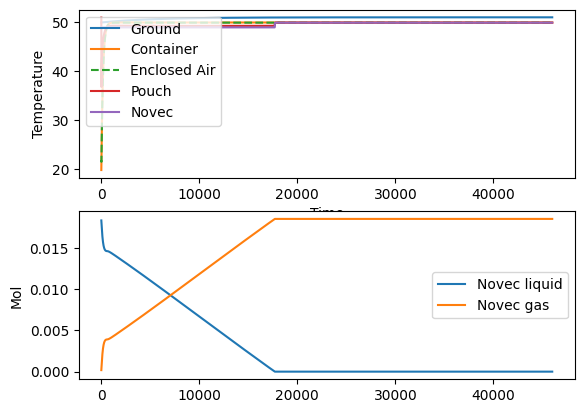

In [28]:
T_g = y[0,:]
T_co = y[1,:]
T_air = y[2,:]
T_p = y[3,:]
T_n = y[4,:]
n_g = y[5,:]
n_l = y[6,:]
P = y[7,:]

# Create the primary axis (left y-axis)
fig, (ax1, ax2) = plt.subplots(2)

# Plot T_g and T_co on the primary axis
ax1.plot(sol.t, T_g-273.15, label="Ground")
ax1.plot(sol.t, T_co-273.15, label="Container")
ax1.plot(sol.t, T_air-273.15, label="Enclosed Air", linestyle='--')
ax1.plot(sol.t, T_p-273.15, label="Pouch")
ax1.plot(sol.t, T_n-273.15, label="Novec")
#ax1.plot(t,P/1000-P_amb/1000, label="Pressure")
#ax1.hlines(T_amb-273.15, 0, 24*3600, label="Ambient", linestyle="dashed")
ax1.set_xlabel('Time')
ax1.set_ylabel('Temperature')
ax1.legend(loc='upper left')

# Create the secondary axis (right y-axis) sharing the same x-axis
#ax2 = ax1.twinx()

# Plot intensity on the secondary axis
#t = np.linspace(0, 24*3600, 3600)
#ax2.plot(np.linspace(0, 24*3600, 3600), intensity, label="Solar Intensity", color='r')
#ax2.set_ylabel('Intensity')
ax2.legend(loc='upper right') 
ax2.plot(sol.t, n_l, label = 'Novec liquid')
ax2.plot(sol.t, n_g, label = 'Novec gas')
#ax2.plot(sol.t, n_l+n_g, label = 'n_l+n_g')
ax2.legend()
ax2.set_ylabel('Mol')
#plt.title('Temperature and novec phase Over Time')
#plt.xlim(82.5e3, 90e3)
plt.show()



Load data

In [17]:
Location = r"C:\Users\Olivi\Documents\Git\SoRoMa\Thermal_soft_robotics_data\Thermal_actuation\Experimental\Fluidic\Videos"
Foldernames = ["//Data"]

data = FluidicSetupFunctions.LoadData(Foldernames = Foldernames,Location=Location)

Loading... Folder 1 of 1, Sample 1 of 2
Loading... Folder 1 of 1, Sample 2 of 2


In [18]:
sample_rate = data[1]['Samplerate'][0]
sample_rate

250

In [31]:
((n0_air+0.4)*R*(273+50)/(0.5e-3))/1000


7576.305033531154

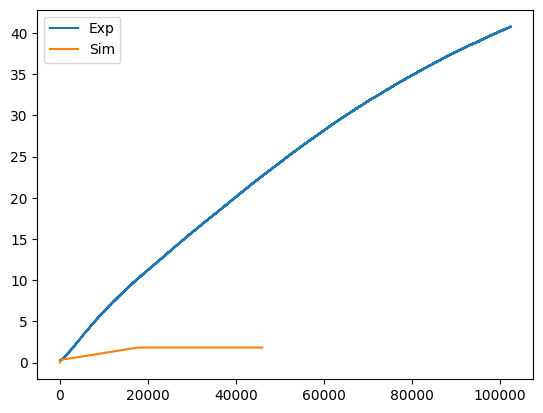

In [34]:
P = (n_g)*R*(50+273)/V_c+1e5
t_start_exp = 50*sample_rate
t_end_exp = 460*sample_rate
P_exp = data[0][1]['MPX100-3'][t_start_exp:t_end_exp]
t_exp = data[0][1]['Time'][t_start_exp:t_end_exp]
plt.plot((t_exp-50)*250, P_exp/1000,label = 'Exp')
plt.plot(t,P/1000-P_amb/1000, label="Sim")
#plt.xlim(50,60)
plt.legend()
